# 20160221-predict-household-income-from-census

Related post:  
https://stharrold.github.io/20160221-predict-household-income-from-census.html

Data documentation:  
https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html  
https://usa.ipums.org/usa/volii/2000pumas.shtml  
https://www.census.gov/geo/maps-data/data/gazetteer2000.html  
https://www.census.gov/geo/maps-data/data/gazetteer2010.html  

## Initialization

### Imports

In [ ]:
cd ~

In [ ]:
# Import standard packages.
import collections
import functools
import itertools
import json
import os
import pdb # Debug with pdb.
import pprint
import sys
import time
import warnings
# Import installed packages.
import astroML.density_estimation as astroML_dens # TODO: remove
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import seaborn as sns
# Import local packages.
# Insert current directory into module search path.
# Autoreload local packages after editing.
# `dsdemos` version: https://github.com/stharrold/dsdemos/releases/tag/v0.0.5
sys.path.insert(0, os.path.join(os.path.curdir, r'dsdemos'))
%reload_ext autoreload
%autoreload 2
import dsdemos as dsd
%matplotlib inline

In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sk.__version__)
print("dsdemos:", dsd.__version__)

Timestamp:
2016-02-13T19:47:47GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=1, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.10.4
pandas: 0.17.1
seaborn: 0.7.0
sklearn: 0.17
dsdemos: 0.0.5


### Globals

File sources:
* 2013 5-year PUMS data dictionary: [PUMS_Data_Dictionary_2009-2013.txt](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt) (<1&nbsp;MB)
* 2013 5-year PUMS person and housing records for District of Columbia:
    * Person records: [csv_pdc.zip](http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/csv_pdc.zip) (5&nbsp;MB compressed, 30&nbsp;MB decompressed)
    * Housing records: [csv_hdc.zip](http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/csv_hdc.zip) (2&nbsp;MB compressed, 13&nbsp;MB decompressed)
* 2000 Census for District of Columbia:
    * Mapping from PUMA to tract: [2000PUMAsASCII.txt](https://usa.ipums.org/usa/volii/2000PUMAsASCII.txt) (14&nbsp;MB)
    * Gazetteer file for tracts: [ustracts2k.zip](http://www2.census.gov/geo/docs/maps-data/data/gazetteer/ustracts2k.zip) (2&nbsp;MB compressed, 8&nbsp;MB decompressed)
* 2010 Census for District of Columbia:
    * Gazetteer file for PUMAs: [2010_Gaz_PUMAs_national.zip](PUMAhttp://www2.census.gov/geo/docs/maps-data/data/gazetteer/2010_Gaz_PUMAs_national.zip) (<1&nbsp;MB compressed, <1&nbsp;MB decompressed)

In [4]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=0) # Set random state for reproducibility.

# File paths
path_static = os.path.join(os.path.expanduser(r'~'), r'stharrold.github.io/content/static')
basename = r'20160221-predict-household-income-from-census'
filename = basename
path_ipynb = os.path.join(path_static, basename, filename+'.ipynb')
path_disk = os.path.abspath(r'/mnt/disk-20151227t211000z/')
path_acs = os.path.join(path_disk, r'www2-census-gov/programs-surveys/acs/')
path_dtxt = os.path.join(path_acs, r'tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt')
path_pcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13pdc.csv') # 'pdc' = 'person DC'
path_hcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13hdc.csv') # 'hdc' = 'housing DC'
# TEST: with mapping
path_m00txt = os.path.join(path_disk, r'usa-ipums-org/usa/volii/2000PUMAsASCII.txt') # 2000 Census map tract to PUMA
path_geo = os.path.join(path_disk, r'www2-census-gov/geo/docs/maps-data/')
path_g00txt = os.path.join(path_geo, r'data/gazetteer/ustracts2k.txt') # 2000 Census tracts
path_g10txt = os.path.join(path_geo, r'data/gazetteer/2010_Gaz_PUMAs_national.txt') # 2010 Census PUMAs


# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

## Extract, transform, and load

Related post:  
https://stharrold.github.io/20160110-etl-census-with-python.html

### Data dictionary

In [5]:
print("`ddict`: Load the data dictionary.")
ddict = dsd.census.parse_pumsdatadict(path=path_dtxt)

`ddict`: Load the data dictionary.


### Gazetteer files

**TODO** for blog:
* Making maps from the GPS data is a future step for visualization. See under "Public Use Microdata Areas (PUMAs)" https://www.census.gov/geo/maps-data/maps/reference.html
* See thematic maps for pre-tabulated visualizations of characteristics of an area: https://www.census.gov/geo/maps-data/maps/thematic.html
* Guide to maps data products: https://www.census.gov/geo/maps-data/
* Gazetteer files good for looking up lat-lon from PUMA code, but don't provide the shape of the PUMA for making maps (a future step): https://www.census.gov/geo/maps-data/data/gazetteer.html, https://en.wikipedia.org/wiki/Gazetteer
    * Gazetteer files don't include tabulations of PUMAs for 2000.
    * Can use https://usa.ipums.org/usa/volii/2000PUMAsASCII.txt to lookup census tracts per PUMA for Census 2000. Parent page with description: https://usa.ipums.org/usa/volii/2000pumas.shtml
    * 2000 Census Gazetteer files description, fixed-width-format: https://www.census.gov/geo/maps-data/data/gazetteer2000.html > click "Census Tracts"
    * From the ipums.org mapping, some state-county-tract combinations belong to more than one PUMA, and the state-county-tract combinations from ipums.org do not include all those from census.gov. 
* Guide to TIGER/Line shapefiles: https://www.census.gov/geo/maps-data/data/tiger-line.html
    * Only state-based files have PUMAs shapes (table 2, and sec 5.15 of http://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2010/TGRSHP10SF1.pdf)
    * For zipcode shape files, see sec 5.26 of http://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2010/TGRSHP10SF1.pdf? (can also query google maps api)
    * Census 2000 shapefiles: https://www.census.gov/geo/maps-data/data/cbf/cbf_puma.html, http://www2.census.gov/geo/tiger/PREVGENZ/pu/p500shp/ (NOTE: missing latitude-longitude)
    * Census 2010 shapefiles: https://www.census.gov/geo/maps-data/data/tiger-line.html, ftp://ftp2.census.gov/geo/pvs/tiger2010st/11_District_of_Columbia/11/
* Reference about PUMAs: https://www.census.gov/geo/reference/puma.html
* Useful brief overview: http://cimms.ou.edu/~lakshman/spatialprogramming/chapter03_basicgis/ch03_basicgis.pdf (http://cimms.ou.edu/~lakshman/spatialprogramming/spatialprogramming.htm)
* To open and read shape files: https://pypi.python.org/pypi/pyshp, https://github.com/GeospatialPython/pyshp (readmes include file format descriptions)
* To convert shapefiles to geojson with pyshp: http://geospatialpython.com/2013/07/shapefile-to-geojson.html
* To convert shapefiles to geojson with ogr2ogr: http://ben.balter.com/2013/06/26/how-to-convert-shapefiles-to-geojson-for-use-on-github/
* Also see https://pypi.python.org/pypi/geojson/, http://www.gdal.org/ogr2ogr.html


In [28]:
print(
    r"""`stpuma00_latlon`, `stpuma10_latlon`: Load and parse Gazetteer files to make
dictionaries mapping combined state-PUMA codes to latitude and longitude.""")
print()
time_start = time.perf_counter()

# Map 2000 Census state-PUMA codes to latitude-longitude coordinates
# by mapping state-PUMA codes to 2000 Census state-county-tract then
# 2000 Census state-county-tract to latitude-longitude coordinates.
# Load the 2000 Census tract-latlon gazetteer file (`df_g00`)
# Column descriptions under "Census Tracts" from
# https://www.census.gov/geo/maps-data/data/gazetteer2000.html
with open(path_g00txt, encoding='utf-8', errors='replace') as fobj:
    df_g00 = pd.read_fwf(
        fobj, colspecs=[(2,13), (87,101), (101,116)], header=None,
        names=['fips_st_cnty_tract', 'INTPTLAT', 'INTPTLONG'])
df_g00['fips_st_cnty_tract'] = df_g00['fips_st_cnty_tract'].apply(lambda item: str(item).rjust(11, '0'))
if not len(df_g00['fips_st_cnty_tract']) == len(df_g00['fips_st_cnty_tract'].unique()):
    raise AssertionError(
        ("Program error. Each state-county-tract combination must be unique.\n" +
         "Required: len(df_g00['fips_st_cnty_tract']) == len(df_g00['fips_st_cnty_tract'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df_g00['fips_st_cnty_tract']), rhs=len(df_g00['fips_st_cnty_tract'].unique())))
# Load the 2000 Census tract-PUMA mapping (`df_m00`). Column descriptions from file header.
# Note: Python engine for pandas.read_fwf casts NaN as np.float64 rather than np.nan.
colspecs = [
    (1,4), (5,7), (8,13), (14,19), (20,23),
    (24,29), (30,35), (36,37), (38,44), (45,49),
    (50,54), (55,63), (64,125)]
names = [
    'summary_code', 'fips_st', 'super_puma', 'puma', 'fips_cnty',
    'fips_cnty_sub', 'fips_place', 'in_city', 'tract', 'stat_code_con',
    'stat_code_pri', 'popl', 'area_name']
df_m00 = pd.read_fwf(path_m00txt, header=41, colspecs=colspecs, names=names)
widths = np.diff(np.asarray(colspecs))[:, 0]
for (name, width) in zip(names, widths):
    if name != 'popl' and df_m00[name].dtype == 'float64':
        df_m00[name] = df_m00[name].apply(
            lambda item: str(int(item)).rjust(width, '0') if pd.notnull(item) else item)
df_m00['fips_st_cnty_tract'] = df_m00['fips_st'] + df_m00['fips_cnty'] + df_m00['tract']
df_m00['GEOID'] = df_m00['fips_st'] + df_m00['puma']
df_m00 = df_m00[['fips_st_cnty_tract', 'GEOID']]
df_m00.dropna(axis=0, how='any', inplace=True)
df_m00.drop_duplicates(keep='first', inplace=True)
if not len(df_m00['fips_st_cnty_tract']) == len(df_m00['fips_st_cnty_tract'].unique()):
    warnings.warn(
        ("Some state-county-tract combinations belong to more than one PUMA.\n" +
         "Required: len(df_m00['fips_st_cnty_tract']) == len(df_m00['fips_st_cnty_tract'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df_m00['fips_st_cnty_tract']), rhs=len(df_m00['fips_st_cnty_tract'].unique())))
if not len(df_g00['fips_st_cnty_tract'].unique()) == len(df_m00['fips_st_cnty_tract'].unique()):
    warnings.warn(
        ("The number of unique state-county-tract combinations do not match.\n" +
         "Required: len(df_g00['fips_st_cnty_tract'].unique()) == len(df_m00['fips_st_cnty_tract'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df_g00['fips_st_cnty_tract'].unique()), rhs=len(df_m00['fips_st_cnty_tract'].unique())))
df_mg00 = pd.merge(left=df_m00, right=df_g00, how='outer', on='fips_st_cnty_tract', suffixes=('_m', '_g'))
df_mg00.drop(labels='fips_st_cnty_tract', axis=1, inplace=True)
stpuma00_latlon = df_mg00.groupby(by='GEOID').agg(np.mean).to_dict(orient='index')

# Map 2010 Census state-PUMA codes to latitude-longitude coordinates
# directly from the gazetteer file.
# Note: The gazetteer files are not all encoded in UTF-8.
#     Replace encoding errors when found.
with open(path_g10txt, encoding='utf-8', errors='replace') as fobj:
    df_g10 = pd.read_csv(fobj, sep='\t')
df_g10.columns = pd.Index(map(str.strip, df_g10.columns))
df_g10['GEOID'] = df_g10['GEOID'].apply(lambda code: str(code).rjust(7, '0'))
df_g10.set_index(keys=['GEOID'], inplace=True, verify_integrity=True)
stpuma10_latlon = df_g10[['INTPTLAT', 'INTPTLONG']].to_dict(orient='index')

# Summarize mappings.
print("Number of 'state-PUMA00' codes:", len(stpuma00_latlon))
print("Number of 'state-PUMA10' codes:", len(stpuma10_latlon))
print("First 5 `stpuma10_latlon`:")
for puma in sorted(stpuma10_latlon)[:5]:
    print(puma+':', stpuma10_latlon[puma])
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

`stpuma00_latlon`, `stpuma10_latlon`: Load and parse Gazetteer files to make
dictionaries mapping combined state-PUMA codes to latitude and longitude.

Number of 'state-PUMA00' codes: 1037
Number of 'state-PUMA10' codes: 2378
First 5 `stpuma10_latlon`:
0100100: {'INTPTLONG': -87.764577000000003, 'INTPTLAT': 34.649881000000001}
0100200: {'INTPTLONG': -86.803207, 'INTPTLAT': 34.811886000000001}
0100301: {'INTPTLONG': -86.692472999999993, 'INTPTLAT': 34.758590999999996}
0100302: {'INTPTLONG': -86.563981999999996, 'INTPTLAT': 34.687967}
0100400: {'INTPTLONG': -85.906204000000002, 'INTPTLAT': 34.644494000000002}

Time elapsed (sec) = 8.4


/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: UserWarning: Some state-county-tract combinations belong to more than one PUMA.
Required: len(df_m00['fips_st_cnty_tract']) == len(df_m00['fips_st_cnty_tract'].unique())
Given: 24817 == 24275
/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: UserWarning: The number of unique state-county-tract combinations do not match.
Required: len(df_g00['fips_st_cnty_tract'].unique()) == len(df_m00['fips_st_cnty_tract'].unique())
Given: 66304 == 24275


#### TODO: With relationship files?

* Relationship files: https://www.census.gov/geo/maps-data/data/relationship.html
* Possible routes: latlon to 2000_tracts; 2000_tracts to 2000_pumas (file does not exist)

### PUMS data

**TODO** for blog:
* Useful link: For learning and testing regular expressions: http://regexr.com/
* Useful link: For comparing SQL and pandas 'JOIN' operations: http://pandas.pydata.org/pandas-docs/stable/merging.html


In [29]:
print(
    r"""`df`: Load and join person and housing records.
Join records on 'SERIALNO'. Only keep household records for which there are person records.
Map PUMA codes to latitude-longitude coordinates. Adjust monetary values for inflation.
Cast all values to floats. Replace null values with -9 (-9 is a common null value
in census data, see `ddict`). Shuffle rows.
`ddict_added`: Data dictionary for added columns.""")
print()
time_start = time.perf_counter()

# Note: The code blocks within this cell are a stictly ordered process.

# Step 0:
# Load and join person and housing CSVs. Join on 'SERIALNO'.
# Only keep households for which there are person records.
# Note: For ss13pdc.csv, low_memory=False since otherwise pandas raises DtypeWarning.
dfp = pd.read_csv(path_pcsv, low_memory=False)
dfh = pd.read_csv(path_hcsv)
# Assert that all housing records are unique.
if not len(dfh) == len(dfh['SERIALNO'].unique()):
    raise AssertionError(
        ("Program error. All household records must be unique.\n" +
         "Required: len(dfh) == len(dfh['SERIALNO'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(dfh), rhs=len(dfh['SERIALNO'].unique())))

# Step 1:
# `df`: Join (merge) person and housing records on 'SERIALNO'.
# `ddict_added`: Data dictionary for added columns.
df = pd.merge(left=dfp, right=dfh, how='left', on='SERIALNO', suffixes=('_p', '_h'))
ddict_added = dict()
# Assert all records identify people.
if not len(df) == len(dfp):
    raise AssertionError(
        ("Program error. All records must identify people.\n" +
         "Required: len(df) == len(dfp)\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df), rhs=len(dfp)))

# Step 2:
# Assert that shared columns have same values
# (except for record type 'RT') then delete
# the duplicate from the housing records.
shared_cols = set(dfp.columns.values)
shared_cols.intersection_update(dfh.columns.values)
suffixed_cols = collections.defaultdict(list)
for col in df.columns:
    (base, *suffix) = col.rsplit(sep='_', maxsplit=1)
    if (((suffix == ['p']) or (suffix == ['h']))
        and (base in shared_cols)):
        suffixed_cols[base].append(col)
for (col, (colp, colh)) in suffixed_cols.items():
    if np.all(df[colp] == df[colh]):
        df[col] = df[colp]
        df.drop(labels=[colp, colh], axis=1, inplace=True)
    elif col == 'RT':
        df[col] = df[colp]
        df.drop(labels=[colp, colh], axis=1, inplace=True)
    else:
        raise AssertionError(
            ("Program error. All shared columns must have the same values\n" +
             "before deleting, except for record type 'RT'.\n" +
             "Required: np.all(df[colp] == df[colh])\n" +
             "colp = {colp}\n" +
             "colh = {colh}").format(colp=colp, colh=colh))

# Step 3:
# Map PUMA codes to latitude-longitude coordinates.
# Remove temporary columns ('s' prefix for 'string').
df['sST'] = df['ST'].apply(lambda code: str(code).rjust(2, '0'))
tmp_cols = ['sST']
for (puma, dobj) in zip(('PUMA00', 'PUMA10'), (stpuma00_latlon, stpuma10_latlon)):
    spuma = 's'+puma
    df[spuma] = df[puma].apply(lambda code: str(code).rjust(5, '0'))
    tmp_cols.append(spuma)
    df['sST_'+spuma] = df['sST'] + df[spuma]
    tmp_cols.append('sST_'+spuma)
    df['sST_'+spuma+'_latlon'] = df['sST_'+spuma].apply(dobj.get)
    tmp_cols.append('sST_'+spuma+'_latlon')
    df['sST_'+spuma+'_lat'] = df['sST_'+spuma+'_latlon'].apply(
        lambda item: item['INTPTLAT'] if not (item is None) else item)
    tmp_cols.append('sST_'+spuma+'_lat')
    df['sST_'+spuma+'_lon'] = df['sST_'+spuma+'_latlon'].apply(
        lambda item: item['INTPTLONG'] if not (item is None) else item)
    tmp_cols.append('sST_'+spuma+'_lon')
for coord in ['lat', 'lon']:
    df[coord] = df['sST_sPUMA00_'+coord]
    df[coord].update(df['sST_sPUMA10_'+coord])
ddict_added['lat'] = 'Latitude in decimal degrees.'
ddict_added['lon'] = 'Longitude in decimal degrees.'
df.drop(labels=tmp_cols, axis=1, inplace=True)

# Step 4:
# Adjust for inflation to 2013-dollars.
# The adjustment factors have 6 implied decimal places.
# See the data dictionary description for
#     'ADJHSG' (only housing records)
#     'ADJINC' (in housing and person records).
# Example: USD_2013 = ADJINC_2010_TO_2013 * USD_2010
# Note: 'INSP' is not in data dictionary, so don't use.
df['ADJHSG'] *= 1e-6
adjhsg_cols = [
    'CONP', 'ELEP', 'FULP', 'GASP', 'GRNTP', 'MHP',
    'MRGP', 'SMOCP', 'RNTP', 'SMP', 'WATP']
for col in adjhsg_cols:
    df[col] *= df['ADJHSG']
df['ADJINC'] *= 1e-6
adjinc_cols = [
    'INTP', 'OIP', 'PAP', 'PERNP', 'PINCP', 'RETP',
    'SEMP', 'SSIP', 'SSP', 'WAGP', 'FINCP', 'HINCP']
for col in adjinc_cols:
    df[col] *= df['ADJINC']

# Step 5:
# Replace special string values with customized floats.
# Replace null values with -9.
# Note: Null values are often replaced in census data with -9.
#     See data dictionary `ddict`.
obj_cols = df.dtypes[df.dtypes == 'object'].index
for col in obj_cols:
    # 'RT' record types.
    # Cast to an integer.
    if 'RT' in col:
        df[col] = df[col].apply(ord)
    # 'SOC' occupational codes.
    # Replace 'X','Y' with '0'.
    if 'SOCP' in col:
        df[col] = df[col].str.replace('X', '0')
        df[col] = df[col].str.replace('Y', '0')
        df[col] = df[col].replace(
            to_replace=r'N\.A\.(\/\/)?', value=-9.0, inplace=False, regex=True)
    # 'OCC' occupational codes.
    if 'OCCP' in col:
        df[col] = df[col].replace(
            to_replace=r'N\.A\.(\/\/)?', value=-9.0, inplace=False, regex=True)
    # 'NAICSP' industry codes.
    # Replace records with formatting errors, which include the string '\D'.
    # Pad all codes on the right (left-justified) with '0'.
    if 'NAICSP' in col:
        df[col] = df[col].str.replace(r'\D', '0')
        ndigits = df[col].apply(lambda obj: len(str(obj))).max()
        df[col] = df[col].str.ljust(ndigits, '0')
    df[col] = df[col].astype(float)

# Step 6:
# Cast all values to float.
# Replace null values with -9.
# Note: Null values are often replaced in census data with -9.
#     See data dictionary `ddict`.
# Shuffle all rows.
df = df.astype(float)
df.fillna(value=-9.0, inplace=True)
df = df.iloc[np.random.permutation(np.arange(len(df.index)))]

print("Number of (rows, columns):")
print("`{name}`:".format(name=name))
print("    Number of (rows, columns) = {tup}".format(tup=np.shape(df)))
print("    RAM usage (MB) = {mem:.1f}".format(mem=df.memory_usage().sum()/1e6))
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))
print()

print("First 5 shuffled records:")
df.head()

`df`: Load and join person and housing records.
Join records on 'SERIALNO'. Only keep household records for which there are person records.
Map PUMA codes to latitude-longitude coordinates. Adjust monetary values for inflation.
Cast all values to floats. Replace null values with 0. Shuffle rows.

Number of (rows, columns):
`area_name`:
    Number of (rows, columns) = (30559, 496)
    RAM usage (MB) = 121.3

Time elapsed (sec) = 5.2

First 5 shuffled records:


,SERIALNO,SPORDER,PWGTP,AGEP,CIT,CITWP05,CITWP12,COW,DDRS,DEAR,...,WGTP78,WGTP79,WGTP80,PUMA00,RT,PUMA10,ST,ADJINC,lat,lon
20239,2.012001e+12,3,21,59,5,0,0,1,2,2,...,21,8,12,-9,80,102,11,1.024887,38.954697,-77.024820
9348,2.010001e+12,1,18,54,1,0,0,0,1,2,...,0,0,0,105,80,-9,11,1.076540,38.903390,-77.028385
18051,2.012000e+12,1,12,51,1,0,0,0,1,2,...,22,4,10,-9,80,103,11,1.024887,38.912802,-76.982277
16402,2.011001e+12,2,12,35,1,0,0,2,2,2,...,13,5,24,103,80,-9,11,1.054614,38.909886,-76.989717
17418,2.011001e+12,1,10,44,1,0,0,1,2,2,...,3,9,17,105,80,-9,11,1.054614,38.903390,-77.028385


`df_ftrs`, `ds_trg`, `df_wts`, `ds_pwt`: Split joined person-housing records into
data frames (series) of features, targets, all weights (unused), and person weights (used).
Shuffle the feature columns.

Number of (rows, columns):
`df_ftrs`:
    Number of (rows, columns) = (30559, 279)
    RAM usage (MB) = 68.2
`ds_trg`:
    Number of (rows, columns) = (30559,)
    RAM usage (MB) = 0.2
`df_wts`:
    Number of (rows, columns) = (30559, 162)
    RAM usage (MB) = 39.6
`ds_pwt`:
    Number of (rows, columns) = (30559,)
    RAM usage (MB) = 0.2

Describe target variable:
target: HINCP
    length: 8
    description: Household income (past 12 months)
    var_codes:
        bbbbbbbb: N/A(GQ/vacant)
        00000000: No household income
        -0059999: Loss of -$59,999 or more
        -0000001..-0059998: Loss of $1 to -$59,998
        00000001: $1 or Break even
        00000002..99999999: Total household income in dollars (Components are rounded)
    notes: ['Note: Use values from ADJINC to a

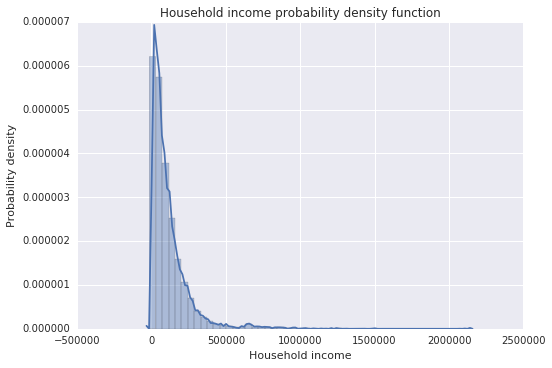

Statistical summary of target variable:
count      30559.000000
mean      113897.186983
std       145755.237279
min       -14762.351200
5%             0.000000
15.9%      10146.381300
50%        72128.180000
84.1%     200160.431100
95%       356467.362800
max      2138939.169000
Name: HINCP, dtype: float64

First 5 shuffled records for target variable:
20239     34436.20320
9348          0.00000
18051      3238.64292
16402    145536.73200
17418     92806.03200
Name: HINCP, dtype: float64

Time elapsed (sec) = 1.0


In [30]:
print(
    r"""`df_ftrs`, `ds_trg`, `df_wts`, `ds_pwt`: Split joined person-housing records into
data frames (series) of features, targets, all weights (unused), and person weights (used).
Shuffle the feature columns.""")
# Note: The `df_ftrs`, `ds_trg`... data frames are views of `df`, not copies of subsets of `df`.
print()
time_start = time.perf_counter()

# Define columns.
# Define columns for weights.
pwt = 'PWGTP' # person weight
pwts = [pwt+str(inum) for inum in range(1, 81)]
hwt = 'WGTP' # housing weight
hwts = [hwt+str(inum) for inum in range(1, 81)]
wts = [pwt] + pwts + [hwt] + hwts
# Define column for target: household income.
trg = 'HINCP'
# Define columns to exclude.
# Note:
#     * Individually listed columns were selected from descriptions.
#     * Because this example is for predicting household income,
#         exclude all columns that must be adjusted for inflation.
#         These are often related to income.
#     * Because the application is predicting household income,
#         exclude obviously highly predictive features such as
#         'POVPIP' = income-to-poverty ratio or 'TAXP' = property taxes.
#         See the `feature_importances_` attribute of the estimator below.
#     * Exclude columns that don't have a clear interpretation,
#         e.g. 'SRNT' = "specified rent unit".
#     * Excluded flag version of excluded columns.
excl_cols = [trg] + adjhsg_cols + adjinc_cols + [
    'POVPIP', 'TAXP', 'OCPIP', 'VALP', 'GRPIP', 'VEH',
    'MRGX', 'MRGT', 'MRGI', 'SMX', 'SRNT', 'SVAL', 'insp']
excl_cols += ['F'+col for col in excl_cols]
# Define columns for features.
# Select unique columns from person and household records that...
#     ...are in the person/housing CSVs or are derived
#     ...aren't weights
#     ...are not an excluded column
# Shuffle feature columns.
ftrs = set(df.columns)
ftrs.difference_update(wts)
ftrs.difference_update(excl_cols)
ftrs = np.random.permutation(list(ftrs))
if trg in ftrs:
    raise AssertionError(
        ("Program error. Target column (`trg`) is in features (`ftrs`).\n" +
         "trg = {trg}").format(trg=trg))

# Separate data frame into features, target, weights.
# Note: These data frames are views of `df`, not copies of subsets of `df`.
df_ftrs = df[ftrs]
ds_trg = df[trg]
df_wts = df[wts]
ds_pwt = df[pwt]
print("Number of (rows, columns):")
for (name, obj) in [
    ('df_ftrs', df_ftrs), ('ds_trg', ds_trg),
    ('df_wts', df_wts), ('ds_pwt', ds_pwt)]:
    print("`{name}`:".format(name=name))
    print("    Number of (rows, columns) = {tup}".format(
        tup=np.shape(obj)))
    if isinstance(obj, pd.DataFrame):
        print("    RAM usage (MB) = {mem:.1f}".format(
            mem=obj.memory_usage().sum()/1e6))
    elif isinstance(obj, pd.Series):
        print("    RAM usage (MB) = {mem:.1f}".format(
            mem=obj.memory_usage()/1e6))
print()

print("Describe target variable:")
print("target: {trg}".format(trg=trg))
for (key0, val0) in ddict['record_types']['HOUSING RECORD'][trg].items():
    if isinstance(val0, dict):
        print("    {key}:".format(key=key0))
        for (key1, val1) in val0.items():
            print("        {key}: {val}".format(key=key1, val=val1))
    else:
        print("    {key}: {val}".format(key=key0, val=val0))
# Assert that the number of incomes matches the sum of the weights.
# See https://stharrold.github.io/20160110-etl-census-with-python.html
# regarding user verification estimates with weights.
incomes = list()
for tup in zip(ds_trg.values, ds_pwt.astype(int)):
    incomes += itertools.repeat(*tup)
if not len(incomes) == ds_pwt.sum():
    raise AssertionError(
        ("Program error. The total number of incomes equal the sum of the weights.\n" +
         "Required: len(incomes) == ds_pwt.sum()\n" +
         "Given: {lhs} == {rhs}").format(lhs=len(incomes), rhs=ds_pwt.sum()))
sns.distplot(incomes, hist=True, kde=True, norm_hist=True)
plt.title('Household income probability density function')
plt.xlabel('Household income')
plt.ylabel('Probability density')
plt.show()
print("Statistical summary of target variable:")
print(ds_trg.describe(percentiles=percentiles))
print()
print("First 5 shuffled records for target variable:")
print(ds_trg.head())
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

## Select features

**TODO:** For blog:
* Task is to use only marginally informative features.

In [75]:
print(
    r"""Select features by importance. Pollute the dataset with
a random feature to benchmark feature importance. At a minimum,
the features kept must be at least as important as the
'most important' random feature.""")
print()
time_start = time.perf_counter()

# Add different kinds of randomized features and evaluate
# their importance, one at a time.
df_ftrs_rnd = df_ftrs.copy()
size = len(df_ftrs_rnd)
n_subset = int(1e4)
dists = [
    'np.random.laplace(loc=0.0, scale=1.0, size=size)',
    'np.random.logistic(loc=0.0, scale=1.0, size=size)',
    'np.random.lognormal(mean=0.0, sigma=1.0, size=size)',
    'np.random.pareto(a=1.0, size=size)',
    'np.random.poisson(lam=1.0, size=size)',
    'np.random.rayleigh(scale=1.0, size=size)',
    'np.random.standard_cauchy(size=size)',
    'np.random.standard_exponential(size=size)',
    'np.random.standard_normal(size=size)',
    'np.random.uniform(low=-1.0, high=1.0, size=size)']
cols_imps = collections.defaultdict(list)
print("Progress:", end=' ')
for (inum, dist) in enumerate(dists):
    df_ftrs_rnd['random'] = eval(dist)
    (ftrs_train, ftrs_test, trg_train, trg_test, pwt_train, pwt_test) = sk_cv.train_test_split(
        df_ftrs_rnd.values[:n_subset], ds_trg.values[:n_subset], ds_pwt.values[:n_subset], test_size=0.2)
    # Note: n_estimators impact the feature importances but only have a small effect on the relative importances.  
    est = sk_ens.ExtraTreesRegressor(n_estimators=10, n_jobs=-1)
    est.fit(X=ftrs_train, y=trg_train, sample_weight=pwt_train)
    est.score(X=ftrs_test, y=trg_test, sample_weight=pwt_test)
    for (col, imp) in zip(df_ftrs_rnd.columns, est.feature_importances_):
        cols_imps[col].append(imp)
    print("{frac:.0%}".format(frac=(inum+1)/len(dists)), end=' ')
print('\n')

# TODO: insert select features here

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

Select features by importance. Pollute the dataset with
a random feature to benchmark feature importance. At a minimum,
the features kept must be at least as important as the
'most important' random feature.

Progress: 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

Time elapsed (sec) = 47.0


In [100]:
print("Select important features:")
rnd_max_idx = np.argmax(cols_imps['random'])
print("'Most important' random distribution and importance:")
print("    dist = {dist}".format(dist=dists[rnd_max_idx]))
print("    importance = {imp:.3f}".format(imp=cols_imps['random'][rnd_max_idx]))
ftrs_keep = list()
for col in cols_imps:
    if np.min(cols_imps[col]) > rnd_imp_max:
        ftrs_keep.append(col)

Select important features:
'Most important' random distribution and importance:
    dist = np.random.laplace(loc=0.0, scale=1.0, size=size)
    importance = 0.010


In [89]:
df_ftrs_imps = pd.DataFrame.from_dict(cols_imps)[ftrs_keep]
df_ftrs_imps.head()

,WIF,BUS,YBL,TEN,BDSP,RACWHT,NR,HINS1,RNTM,RMSP,lon
0,0.044718,0.077873,0.015776,0.021672,0.034672,0.092779,0.014175,0.015552,0.024367,0.049918,0.034172
1,0.052287,0.080025,0.018671,0.016671,0.026205,0.075742,0.013746,0.015493,0.023060,0.079289,0.034706
2,0.046304,0.034463,0.017017,0.013023,0.049687,0.125086,0.013175,0.014440,0.026936,0.093887,0.031628
3,0.044005,0.050039,0.009833,0.021983,0.042167,0.089334,0.013072,0.013230,0.023407,0.082104,0.044420
4,0.043117,0.038036,0.014830,0.014974,0.052114,0.098521,0.013147,0.012280,0.032152,0.088739,0.039120


In [88]:
test.median().sort_values(ascending=False)

RACWHT    0.103362
RMSP      0.078620
BUS       0.055276
WIF       0.045646
BDSP      0.041889
lon       0.034321
RNTM      0.026167
TEN       0.019070
YBL       0.014518
HINS1     0.014018
NR        0.013161
dtype: float64

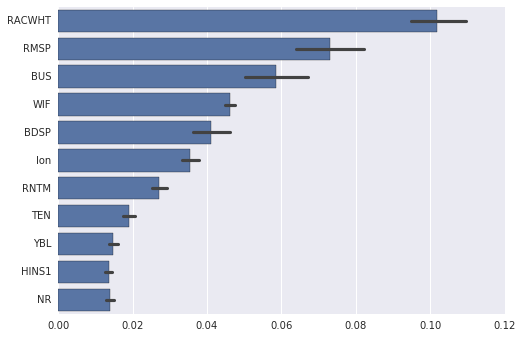

In [94]:
ds_ftrs_medimps = df_ftrs_imps.median().sort_values(ascending=False)
sns.barplot(data=df_ftrs_imps, order=ds_ftrs_medimps.index, ci=90, orient='h', color=sns.color_palette()[0])
plt.show()

In [104]:
print("Score, Column: Description")
for (col, score) in ds_ftrs_medimps.items():
    if col in ddict['record_types']['PERSON RECORD']:
        desc = ddict['record_types']['PERSON RECORD'][col]['description']
    elif col in ddict['record_types']['HOUSING RECORD']:
        desc = ddict['record_types']['HOUSING RECORD'][col]['description']
    else:
        desc = None
    print("{score:.3f}, {col}: {desc}".format(
            score=score, col=col, desc=desc))

Score, Column: Description
0.103, RACWHT: White recode (White alone or in combination with one or more other races)
0.079, RMSP: Number of Rooms
0.055, BUS: Business or medical office on property
0.046, WIF: Workers in family during the past 12 months
0.042, BDSP: Number of bedrooms
0.034, lon: None
0.026, RNTM: Meals included in rent
0.019, TEN: Tenure
0.015, YBL: When structure first built
0.014, HINS1: Insurance through a current or former employer or union
0.013, NR: Presence of nonrelative in household


In [22]:
for (score, col) in sorted(zip(estimator.feature_importances_, df_ftrs_rnd.columns), reverse=True):
    if col in ddict['record_types']['PERSON RECORD']:
        desc = ddict['record_types']['PERSON RECORD'][col]['description']
    elif col in ddict['record_types']['HOUSING RECORD']:
        desc = ddict['record_types']['HOUSING RECORD'][col]['description']
    else:
        desc = None
    print("{score:.4f},\t{col},\n\t{desc}".format(
            score=score, col=col, desc=desc))

0.1056,	RMSP,
	Number of Rooms
0.1004,	RACWHT,
	White recode (White alone or in combination with one or more other races)
0.0459,	WIF,
	Workers in family during the past 12 months
0.0414,	BDSP,
	Number of bedrooms
0.0349,	lon,
	None
0.0348,	BUS,
	Business or medical office on property
0.0232,	RNTM,
	Meals included in rent
0.0226,	ACR,
	Lot size
0.0190,	RACBLK,
	Black or African American recode (Black alone or in combination with one or more other races)
0.0178,	YBL,
	When structure first built
0.0138,	SCIENGP,
	Field of degree science and engineering flag - NSF definition
0.0131,	WKHP,
	Usual hours worked per week past 12 months
0.0131,	NR,
	Presence of nonrelative in household
0.0126,	HINS1,
	Insurance through a current or former employer or union
0.0122,	TEN,
	Tenure
0.0096,	NP,
	Number of person records following this housing record
0.0096,	FOD1P,
	Recoded field of degree - first entry
0.0095,	WKEXREL,
	Work experience of householder and spouse
0.0086,	RESMODE,
	Response mode
0.0085

In [68]:
np.mean(estimator.feature_importances_)

0.0035460992907801418

In [ ]:
### TODO: resume here 20160210
# * Create lat-lon mapping of PUMAs.
#     * From data dictionary, use PUMA00 (PUMA code for Census 2000 5-percent sample since 5-year data is ~5% of population)
#         with data collected before 2012; use PUMA10 (PUMA code for Census 2010) with data collected on or after 2012.
#         The first 4 digits of SERIALNO give the year that the data was collected.
#     * For Census 2010, PUMA code in TIGER and Gazetter is 'ST'+'PUMA10'
#         ('ST' is 'Federal Information Processing Series' FIPS code)
#     * For Census 2000, lookup PUMA code 'ST'+'PUMA00' in https://usa.ipums.org/usa/volii/2000PUMAsASCII.txt,
#         then lookup collection of tracts in TIGER or Gazetteer.
# * Select features with more than highest random importance.
# * Check that spark mlib has this kind of random forest implementation.
# * Tune hyperparameters. Experiment with 'bootstrap' and 'oob_score'.
# * Make into a pipeline.
# * Cross-validate scores of predicted household income.
# * Plot predicted vs actual.
# * Plot marginalized importances.

In [69]:
df_ftrs['PUMA00'].unique()

array([ 101.,  103.,   -9.,  105.,  102.,  104.])

In [73]:
df_ftrs['PUMA10'].unique()

array([  -9.,  103.,  104.,  101.,  102.,  105.])

In [72]:
df_ftrs['ST'].unique()

array([ 11.])

In [71]:
ddict['record_types']['HOUSING RECORD']['PUMA00']

OrderedDict([('length', '5'),
             ('description',
              'Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.'),
             ('var_codes',
              OrderedDict([('00100..08200', 'Public use microdata area codes'),
                           ('77777',
                            'Combination of 01801, 01802, and 01905 in Louisiana'),
                           ('-0009',
                            'Code classification is Not Applicable because data collected in 2012 or later')])),
             ('notes',
              ['Note: Public Use Microdata Areas (PUMAs) designate areas of 100,000 or more population.  Use with ST for unique code. PUMA00 applies to data collected in calendar years 2011 and earlier. Users of multi-year datasets that contain data from before and after 2012 should use PUMA00 and PUMA10 together where possible, but not all PUMAs will be comparable. See http://tigerw

In [30]:
scores = list()
for n_estimators in n_estimators_list:
    time_start = time.perf_counter()
    print("n_estimators={nest}".format(nest=n_estimators), end='; ')
    estimator = sk_ens.ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=n_jobs)
    estimator.fit(X=df_ftrs_train, y=df_trg_train, sample_weight=ds_pwt_train)
    
    sk_met.r2_score(y_true=ds_trg, y_pred=)
    score = np.mean(sk_cv.cross_val_score(
        estimator=estimator, X=df_ftrs, y=ds_trg, scoring='r2', cv=2, n_jobs=n_jobs))
    scores.append(score)
    print("score={scr:.3f}".format(scr=score))
    time_stop = time.perf_counter()
    print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

n_estimators=30; 

KeyboardInterrupt: 

In [39]:
test = sk_cv.train_test_split(df_ftrs, ds_trg, test_size=0.2)
np.shape(test[0]), np.shape(test[1])

((24447, 332), (6112, 332))

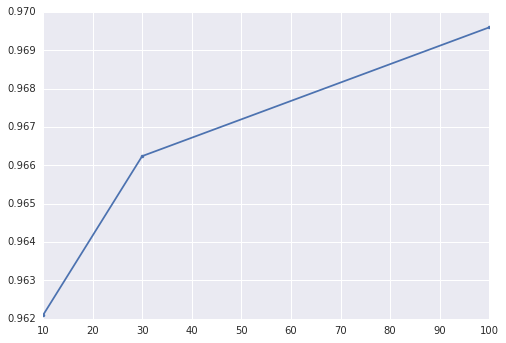

In [28]:
plt.plot(n_estimators_list, scores, marker='.')
plt.show()

In [ ]:
n_jobs = -1
estimator = functools.partial(sk_ens.ExtraTreesRegressor, {'n_jobs': n_jobs})
score = sk_cv.cross_val_score(
    estimator=estimator, X=df_ftrs, y=ds_trg, scoring='r2', cv=5, n_jobs=n_jobs)
score

In [ ]:
model = sk_ens.ExtraTreesRegressor()
model.fit(X=df_ftrs, y=ds_trg)

In [ ]:
model = sk.feature_selection.SelectFromModel(
    estimator=sk_ens.ExtraTreesRegressor(), threshold='mean', prefit=False)
model.fit()

In [ ]:
# TODO: test significance of score
# http://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html

# TODO: redo below

## Select features

**Notes:**
* Example consumer databases: http://www.consumerreports.org/cro/money/consumer-protection/big-brother-is-watching/overview/index.htm?rurl=http%3A%2F%2Fwww.consumerreports.org%2Fcro%2Fmoney%2Fconsumer-protection%2Fbig-brother-is-watching%2Foverview%2Findex.htm
* Random forests are scale invariant, so they can accommodate non-linear transformation.
* Cast all values to floats so that compatable with most algorithms and can use </> logic. Otherwise less informationally dense and may require deeper tree structure to find features.
* To "map to float" ('b' is N/A, mapped to 0; 1 is Yes; 2 is No; other values are special):  
```python
test = pd.DataFrame(data=[['  b', 1.0], ['1', 1.0], ['2', 1.0], ['3', 1.1], ['4', 1.1]], columns=['COL', 'ADJ'])
tfmask = test['COL'].str.contains('b')
test.loc[tfmask, 'COL'] = 0.0
test['COL'] = test['COL'].astype(float)
print(test.dtypes)
test
```
* To "adjust for inflation":  
```python
test['ADJ'] *= 1e-6
tfmask = test['COL'] >= 3.0
test.loc[tfmask, 'COL'] *= test.loc[tfmask, 'ADJ']
test
```
* TODO: Remove vacant units ('NP') from data frame.
* TODO: Filter categorical variables from metadata (those without '..').

In [66]:
record_type = 'PERSON RECORD'
print_detail = False
for key in ddict['record_types'][record_type]:
    desc = ddict['record_types'][record_type][key]['description']
    if not (
        (key.startswith('F') and (desc.endswith(' flag') or desc.endswith(' edit')))
        or ('WGTP' in key and "Weight replicate" in desc)):
        if print_detail:
            print(key)
            pprint.pprint(ddict['record_types'][record_type][key])
        else:
            print("{key}: {desc}".format(key=key, desc=desc))

RT: Record Type
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data Collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
PWGTP: Person's weight
AGEP: Age
CIT: Citizenship status
CITWP05: Year of naturalization write-in for data collected prior to 2012
CITWP12: Year of naturalization write-in for data collected in 2012 or later
COW: Class of worker
DDRS: Self-care difficulty
DEAR: Hearing difficulty
DEYE: Vision difficulty
DOUT: Independent living difficulty
DPHY: Ambulatory difficulty
DRAT: Veteran service connected disability rating (percentage)
DRATX: Veteran service connected disability rating (checkbox)
DREM: Cognitive diffic

In [85]:
# Include columns that I think companies can easily get.
# for column details: https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html
# target: HINCP

cols_include = {
    'HOUSING RECORD': [
        'SERIALNO', 'PUMA00', 'PUMA10', 'ST', 'ADJHSG', 'ADJINC', 'WGTP', 'NP', 'BDSP', 'BLD', 'HINCP', 'R18', 'R65'],
    'PERSON RECORD': [
        'SERIALNO', 'SPORDER', 'PWGTP', 'AGEP', 'MAR', 'SCHL', 'INDP']
    }

In [86]:
for record_type in cols_include:
    print(record_type)
    for var_name in cols_include[record_type]:
        desc = ddict['record_types'][record_type][var_name]['description']
        print("{var}: {desc}".format(var=var_name, desc=desc))
    print()

HOUSING RECORD
SERIALNO: Housing unit/GQ person serial number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJHSG: Adjustment factor for housing dollar amounts (6 implied decimal places)
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
WGTP: Housing Weight
NP: Number of person records following this housing record
BDSP: Number of bedrooms
BLD: Units in structure
HINCP: Household income (past 12 months)
R18: Presence of persons under 18 years in household (unweighted)
R65: Presence of persons 65 years and over in household (unweighted)

PERSON RECORD
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PWGTP: Person's weight
AGEP: Age
MAR: Marital status
SCHL: Educational

In [80]:
record_type = 'PERSON RECORD'
var_codes = ddict['record_types'][record_type]['INDP']['var_codes']
indp_abbr = dict()
for var_code in var_codes.keys():
    indp_abbr[var_code] = var_codes[var_code].split(sep='-', maxsplit=1)[0][:3]
print(sorted(set(indp_abbr.values())))

['ADM', 'AGR', 'CON', 'EDU', 'ENT', 'EXT', 'FIN', 'INF', 'MED', 'MFG', 'MIL', 'Not', 'PRF', 'RET', 'SCA', 'SRV', 'TRN', 'UNE', 'UTL', 'WHL']


Actions for included columns:  
* HOUSING RECORD
    * SERIALNO: Use to join to PERSON RECORD.
    * PUMA00, PUMA10, ST: Combine and lookup lat-lon coordinates from census.gov.
    * ADJHSG, ADJINC: Multiply against other columns to adjust for inflation. See https://www.census.gov/library/publications/2009/acs/pums.html App 5.
    ADJHSG: CONP, ELEP, FULP, GASP, GRNTP, INSP, MHP, MRGP, SMOCP, RNTP, SMP, WATP
    ADJINC: INTP, OIP, PAP, PERNP, PINCP, RETP, SEMP, SSIP, SSP, WAGP
    * WGTP: Confirm with user verification file.
    * NP: Numerical. Map to float.
    * BDSP: Numerical. Map to float.
    * BLD: Map to median income.
    * HINCP: Include. Map household income to float. Adjust all with ADJINC.
    * R18: Include. Presence of persons under 18 years in household. Map to float.
    * R65: Include. Presence of persons 60+ years in household.
* PERSON RECORD
    * SERIALNO, SPORDER: Use as index.
    * PWGTP: Confirm user verification file.
    * AGEP: Map to float.
    * MAR: Map to float.
    * SCHL: Map to float.
    * INDP: (1) Map to float. (2) Map categories to median income.

## Export ipynb to html

In [158]:
!date --rfc-3339='seconds'

2016-01-01 05:40:17+00:00


In [ ]:
path_ipynb = os.path.join(path_static, basename, basename+'.ipynb')
for template in ['basic', 'full']:
    path_html = os.path.splitext(path_ipynb)[0]+'-'+template+'.html'
    cmd = ['jupyter', 'nbconvert', '--to', 'html', '--template', template, path_ipynb, '--output', path_html]
    print(' '.join(cmd))
    subprocess.run(args=cmd, check=True)